# Домашнее задание №5: Архитектура Stable Diffusion

В данном домашнем задании вам не придется реализовывать диффузионную архитектуру, специфичную для задачи SR, но предлагается реализовать классическую SD для генерации изображений, научившись ее реализовывать, будет не проблемой реализовывать SR модификации.

Исходник кода для данного домашнего задания можно найти по [ссылке](https://github.com/hkproj/pytorch-stable-diffusion), но настоятельно советую попробовать запрограммировать SD самостоятельно. Это даст вам более глубокое понимание для реализации других диффузионных, автоэнкодерных моделей, механизмов SelfAttention, CrossAttention и т.д.

**[0 баллов] Считайте изображение и получите две вариации изображения: HR, LR.**

In [1]:
# скачаем изображение
!wget -O hr.png https://github.com/aiedu-courses/super_resolution/blob/main/data/hr.png?raw=true

--2024-05-30 20:49:02--  https://github.com/aiedu-courses/super_resolution/blob/main/data/hr.png?raw=true
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/aiedu-courses/super_resolution/raw/main/data/hr.png [following]
--2024-05-30 20:49:02--  https://github.com/aiedu-courses/super_resolution/raw/main/data/hr.png
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/aiedu-courses/super_resolution/main/data/hr.png [following]
--2024-05-30 20:49:02--  https://raw.githubusercontent.com/aiedu-courses/super_resolution/main/data/hr.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HT

In [2]:
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from torch import nn
import torch
import torch.nn.functional as F
import math
from typing import Any
import src.sd.model_converter as model_converter
import src.sd.pipeline as pipeline
from transformers import CLIPTokenizer
import os

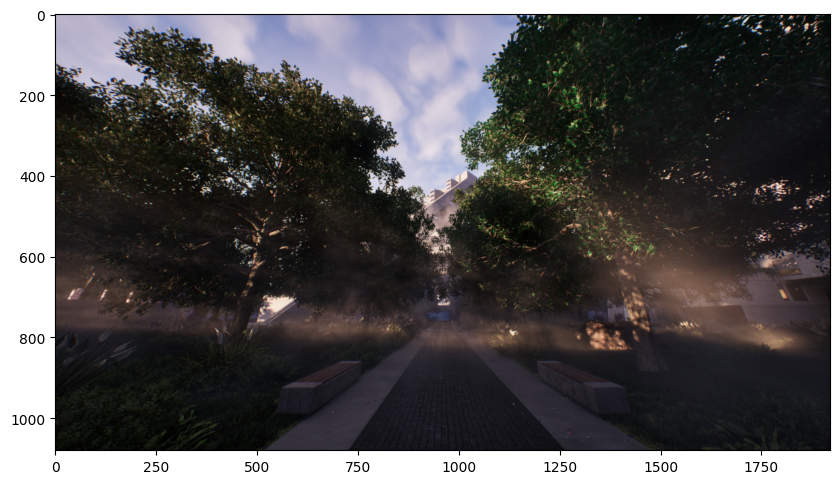

In [3]:
# считаем изображение при помощи библиотеки pillow и приведем к RGB формату
hr_img = Image.open("hr.png").convert("RGB")
_ = plt.figure(figsize=(10, 7))
_ = plt.imshow(hr_img)

In [4]:
# случайным образом получим HR изображение размера (256, 256)
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.RandomCrop((256, 256))
    ]
)

# получим LR изображение размера (64, 64) при помощи простого resize
resize_transform = transforms.Resize((64, 64))

# tensor to PIL
tensor2pil = transforms.ToPILImage()

In [5]:
hr_img = transform(hr_img)
lr_img = resize_transform(hr_img)

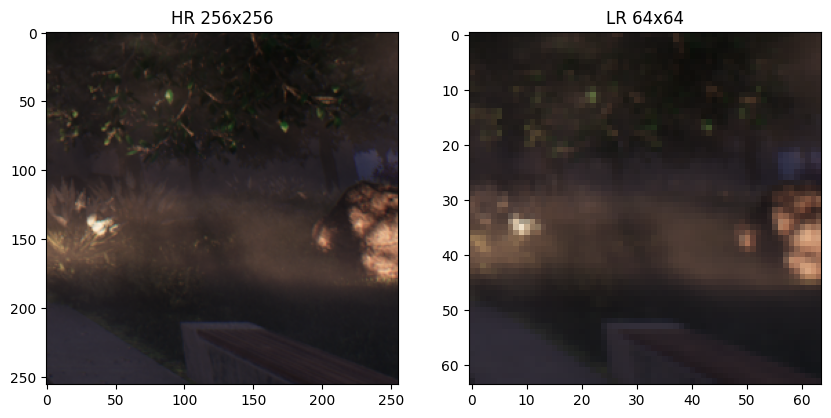

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 7))

ax[0].imshow(tensor2pil(hr_img))
ax[0].set_title("HR 256x256")

ax[1].imshow(tensor2pil(lr_img))
ax[1].set_title("LR 64x64")

plt.show()

In [7]:
hr_img = hr_img.unsqueeze(0)
lr_img = lr_img.unsqueeze(0)

### **[0 баллов] Подсчет параметров модели**

In [8]:
# возьмите реализацию функции из ДЗ №2: Архитектуры CNN
def calculate_total_parameters(model: nn.Module) -> int:
    """
        Parameters
        ----------
        model: nn.Module
            Объект PyTorch модели.

        Returns
        -------
        int
            Число всех параметров модели.
    """
    ...

### **[8 баллов] Self-Attention и Cross-Attention**

In [9]:
# реализуйте объявленные методы класса
class SelfAttention(nn.Module):
    def __init__(self, h: int, d: int, in_bias: bool = True, out_bias: bool = True) -> None:
        super().__init__()
        # проекция в Q, K, V матрицы (bs, c, d) -> (bs, c, 3d)
        self.in_proj = ...
        # проекция в выходной тензор (bs, c, d) -> (bs, c, d)
        self.out_proj = ...
        self.h = h
        self.h_dim = d // h

    def forward(self, x: torch.FloatTensor, mask: bool = False) -> torch.FloatTensor:
        """
            x: (bs, seq_len, d)
        """
        bs, c, d = x.shape

        # (bs, c, d) -> (bs, c, 3d) -> Q, K, V размера (bs, c, d)
        q, k, v = ...  # примените слой проекции входа и torch.chunk для разделения на Q, K и V

        # (bs, c, d) -> (bs, c, h, h_dim) -> (bs, h, c, h_dim)
        q = ...
        k = ...
        v = ...

        # (bs, h, c, h_dim) @ (bs, h, h_dim, c) -> (bs, h, c, c)
        attn = ...  # Q @ K.T

        if mask:
            # при помощи masked_fill_ заполните верхнюю треугольную матрицу в attn значениями -inf
            ...

        # нормировка на корень из h_dim и применение softmax
        attn = ...

        # (bs, h, c, c) @ (bs, h, c, h_dim) -> (bs, h, c, h_dim) -> (bs, c, h, h_dim)
        out = ...  # attn @ V и смена размерностей h и c местами

        # (bs, c, h, h_dim) -> (bs, c, d)
        out = ...  # сделайте reshape к исходному размеру тензора

        # (bs, c, d) -> (bs, c, d)
        out = ...  # примените слой проекции для получения выхода
        return out

In [ ]:
self_attention = SelfAttention(8, 4096)
assert self_attention(torch.zeros((1, 64, 4096))).shape == (1, 64, 4096)
print(f"SelfAttention parameters = {calculate_total_parameters(self_attention)}")

In [11]:
# реализуйте объявленные методы класса
class CrossAttention(nn.Module):
    def __init__(self, h: int, d: int, d_cross: int, in_bias: bool = True, out_bias: bool = True) -> None:
        super().__init__()
        # проекция в матрицу Q, (bs, seq_len_q, d) -> (bs, seq_len_q, d)
        self.q_proj = ...
        # проекция в матрицу K, (bs, seq_len_kv, d_cross) -> (bs, seq_len_kv, d)
        self.k_proj = ...
        # проекция в матрицу V, (bs, seq_len_kv, d_cross) -> (bs, seq_len_kv, d)
        self.v_proj = ...
        # проекция в выходной тензор (bs, seq_len_q, d) -> (bs, seq_len_q, d)
        self.out_proj = ...
        self.h = h
        self.h_dim = d // h

    def forward(self, x: torch.FloatTensor, context: torch.FloatTensor) -> torch.FloatTensor:
        """
            x (latent): (bs, seq_len_q, d)
            context: (bs, seq_len_kv, d_cross) = (bs, 77, 768)
        """
        bs, seq_len_q, d = x.shape
        seq_len_kv = context.shape[1]

        # (bs, seq_len_q, d) -> (bs, seq_len_q, d)
        q = ...  # примените слой проекции в Q над тензором x
        # (bs, seq_len_kv, d_cross) -> (bs, seq_len_kv, d)
        k = ...  # примените слой проекции в K над тензором context
        # (bs, seq_len_kv, d_cross) -> (bs, seq_len_kv, d)
        v = ...  # примените слой проекции в V над тензором context

        # (bs, seq_len_q, d) -> (bs, seq_len_q, h, h_dim) -> (bs, h, seq_len_q, h_dim)
        q = ...
        # (bs, seq_len_kv, d) -> (bs, seq_len_kv, h, h_dim) -> (bs, h, seq_len_kv, h_dim)
        k = ...
        # (bs, seq_len_kv, d) -> (bs, seq_len_kv, h, h_dim) -> (bs, h, seq_len_kv, h_dim)
        v = ...

        # (bs, h, seq_len_q, h_dim) @ (bs, h, h_dim, seq_len_kv) -> (bs, h, seq_len_q, seq_len_kv)
        attn = ...  # Q @ K.T

        # нормировка на корень из h_dim и применение softmax
        attn = ...

        # (bs, h, seq_len_q, seq_len_kv) @ (bs, h, seq_len_kv, h_dim) -> (bs, h, seq_len_q, h_dim) -> (bs, seq_len_q, h, h_dim)
        out = ...  # attn @ V и смена размерностей h и seq_len_q местами

        # (bs, seq_len_q, h, h_dim) -> (bs, seq_len_q, d)
        out = ...  # сделайте reshape к исходному размеру тензора

        # (bs, seq_len_q, d) -> (bs, seq_len_q, d)
        out = ...  # примените слой проекции для получения выхода
        return out

In [ ]:
cross_attention = CrossAttention(8, 4096, 768)
assert cross_attention(torch.zeros((1, 64, 4096)), torch.zeros((1, 77, 768))).shape == (1, 64, 4096)
print(f"CrossAttention parameters = {calculate_total_parameters(cross_attention)}")

### **[10 баллов] VAE**

In [13]:
# реализуйте объявленные методы класса
class VAEAttnBlock(nn.Module):
    def __init__(self, c: int) -> None:
        super().__init__()
        self.group_norm = ...  # слой нормировки GroupNorm по 32 группам для c каналов
        self.attn = ...  # SelfAttention с одной головой и скрытой размерностью c

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        """
            x: (bs, c, h, w)
        """
        r = ...  # сохраним входной тензор для residual connection

        # (bs, c, h, w) -> (bs, c, h, w)
        x = ...  # применим слой GroupNorm
        n, c, h, w = x.shape

        # (bs, c, h, w) -> (bs, c, h * w)
        x = ...  # вытянем 2D пиксели в 1D вектор

        # (bs, c, h * w) -> (bs, h * w, c), теперь размер токена для механизма внимания всегда будет равен c, а количество токенов может меняться - H * W
        x = ...  # поменяйте местами две последних размерности

        # (bs, h * w, c) -> (bs, h * w, c)
        x = ...  # примените слой SelfAttention без маскирования

        # (bs, h * w, c) -> (bs, c, h * w)
        x = ...  # поменяйте последние две размерности

        # (bs, c, h * w) -> (bs, c, h, w)
        x = ...  # получите из 1D пикселей 2D обратным преобразованием

        x += ...  # используйте residual connection
        return x

In [ ]:
vae_attention = VAEAttnBlock(64)
assert vae_attention(torch.zeros(1, 64, 64, 64)).shape == (1, 64, 64, 64)
print(f"VAEAttnBlock parameters = {calculate_total_parameters(vae_attention)}")

In [15]:
# реализуйте объявленные методы класса
class VAEResBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()
        self.group_norm1 = ...  # слой нормировки GroupNorm по 32 группам для in_channels каналов
        # (bs, in_channels, h, w) -> (bs, out_channels, h, w)
        self.conv1 = ...  # свертка k=3, s=1, p=1

        self.group_norm2 = ...  # слой нормировки GroupNorm по 32 группам для out_channels каналов
        # (bs, out_channels, h, w) -> (bs, out_channels, h, w)
        self.conv2 = ...  # свертка k=3, s=1, p=1

        # если количество входных и выходных каналов различается, необходимо использовать свертку 1x1, чтобы размерность x и f(x) совпадала при сложении: r = x + f(x)
        if in_channels == out_channels:
            self.residual = ...  # identity
        else:
            # (bs, in_channels, h, w) -> (bs, out_channels, h, w)
            self.residual = ...  # свертка k=1, s=1, p=0

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        """
            x: (bs, in_channels, h, w)
        """
        r = ...  # сохраним входной тензор для residual connection

        # (bs, in_channels, h, w) -> (bs, in_channels, h, w)
        x = ...  # примените первый слой нормировки

        # (bs, in_channels, h, w) -> (bs, in_channels, h, w)
        x = ...  # примените функцию активации F.silu

        # (bs, in_channels, h, w) -> (bs, out_channels, h, w)
        x = ...  # примените первую свертку

        # (bs, out_channels, h, w) -> (bs, out_channels, h, w)
        x = ...  # примените второй слой нормировки

        # (bs, out_channels, h, w) -> (bs, out_channels, h, w)
        x = ...  # примените функцию активации F.silu

        # (bs, out_channels, h, w) -> (bs, out_channels, h, w)
        x = ...  # примените вторую свертку

        # (bs, out_channels, h, w) + (bs, out_channels, h, w) -> (bs, out_channels, h, w)
        out = ...  # x + f(x), не забудьте применить слой residual
        return out

In [ ]:
vae_r1 = VAEResBlock(64, 64)
assert vae_r1(torch.zeros(1, 64, 64, 64)).shape == (1, 64, 64, 64)
print(f"VAEResBlock v1 parameters = {calculate_total_parameters(vae_r1)}")

vae_r2 = VAEResBlock(64, 128)
assert vae_r2(torch.zeros(1, 64, 64, 64)).shape == (1, 128, 64, 64)
print(f"VAEResBlock v2 parameters = {calculate_total_parameters(vae_r2)}")

In [17]:
# реализуйте объявленные методы класса
class VAEEncoder(nn.Sequential):
    def __init__(self) -> None:
        # (bs, 3, h, w) -> (bs, 128, h, w)
        conv_head = ...  # свертка k=3, s=1, p=1

        # (bs, 128, h, w) -> (bs, 128, h, w)
        r1b1 = ...  # VAE residual блок

        # (bs, 128, h, w) -> (bs, 128, h, w)
        r2b1 = ...  # VAE residual блок

        # (bs, 128, h, w) -> (bs, 128, h / 2 - 1, w / 2 - 1) -> (bs, 128, h / 2, w / 2) с ассиметричным паддингом
        # выставляется padding=0, т.к. мы хотим использовать ассиметричный паддинг в методе forward
        conv_down1 = ...  # свертка k=3, s=2, p=0

        # (bs, 128, h / 2, w / 2) -> (bs, 256, h / 2, w / 2)
        r1b2 = ...  # VAE residual блок

        # (bs, 256, h / 2, w / 2) -> (bs, 256, h / 2, w / 2)
        r2b2 = ...  # VAE residual блок

        # (bs, 256, h / 2, w / 2) -> (bs, 256, h / 4 - 1, w / 4 - 1) -> (bs, 256, h / 4, w / 4) с ассиметричным паддингом
        # выставляется padding=0, т.к. мы хотим использовать ассиметричный паддинг в методе forward
        conv_down2 = ...  # свертка k=3, s=2, p=0

        # (bs, 256, h / 4, w / 4) -> (bs, 512, h / 4, w / 4)
        r1b3 = ...  # VAE residual блок

        # (bs, 512, h / 4, w / 4) -> (bs, 512, h / 4, w / 4)
        r2b3 = ...  # VAE residual блок

        # (bs, 512, h / 4, w / 4) -> (bs, 512, h / 8 - 1, w / 8 - 1) -> (bs, 512, h / 8, w / 8) с ассиметричным паддингом
        # выставляется padding=0, т.к. мы хотим использовать ассиметричный паддинг в методе forward
        conv_down3 = ...  # свертка k=3, s=2, p=0

        # (bs, 512, h / 8, w / 8) -> (bs, 512, h / 8, w / 8)
        r1b4 = ...  # VAE residual блок

        # (bs, 512, h / 8, w / 8) -> (bs, 512, h / 8, w / 8)
        r2b4 = ...  # VAE residual блок

        # (bs, 512, h / 8, w / 8) -> (bs, 512, h / 8, w / 8)
        r3b4 = ...  # VAE residual блок

        # (bs, 512, h / 8, w / 8) -> (bs, 512, h / 8, w / 8)
        attn = ...  # VAE attention блок

        # (bs, 512, h / 8, w / 8) -> (bs, 512, h / 8, w / 8)
        r4b4 = ...  # VAE residual блок

        # (bs, 512, h / 8, w / 8) -> (bs, 512, h / 8, w / 8)
        group_norm = ...  # слой нормировки GroupNorm по 32 группам для 512 каналов

        # (bs, 512, h / 8, w / 8) -> (bs, 512, h / 8, w / 8)
        silu = ...  # функция активации SiLU

        # (bs, 512, h / 8, w / 8) -> (bs, 8, h / 8, w / 8)
        conv_squeeze = ...  # свертка k=3, s=1, p=1

        # (bs, 8, h / 8, w / 8) -> (bs, 8, h / 8, w / 8)
        conv_bottleneck = ...  # свертка k=1, s=1, p=0

        # оборачиваем все слои в nn.Sequential
        super().__init__(
            conv_head,
            r1b1,
            r2b1,
            conv_down1,
            r1b2,
            r2b2,
            conv_down2,
            r1b3,
            r2b3,
            conv_down3,
            r1b4,
            r2b4,
            r3b4,
            attn,
            r4b4,
            group_norm,
            silu,
            conv_squeeze,
            conv_bottleneck
        )

    def forward(self, x: torch.FloatTensor, noise: torch.FloatTensor) -> torch.FloatTensor:
        """
            x: (bs, c, h, w)
            noise: (bs, 4, h / 8, w / 8)
        """
        for m in self:
            if getattr(m, "stride", None) == (2, 2):
                x = ...  # ассиметричный паддинг с pad_left = 0, pad_right = 1, pad_top = 0, pad_bottom = 1
            x = m(x)

        # (bs, 8, h / 8, w / 8) -> два тензора (bs, 4, h / 8, w / 8) - математическое ожидание и логарифмическая дисперсия
        mean, log_var = ...  # используйте torch.chunk по нужной размерности

        # (bs, 4, h / 8, w / 8)
        log_var = ...  # используйте torch.clamp, чтобы ограничить диапазон значений log_var от -30 до 20
        var = ...  # уйдем от логарифма при помощи torch.exp
        std = ...  # найдем стандартное отклонение

        # (bs, 4, h / 8, w / 8) -> (bs, 4, h / 8, w / 8)
        x = ...  # преобразуйте noise из N(0, 1) в N(mean, std)

        # магическая константа из https://github.com/CompVis/stable-diffusion/blob/21f890f9da3cfbeaba8e2ac3c425ee9e998d5229/configs/stable-diffusion/v1-inference.yaml#L17C1-L17C1
        x *= 0.18215
        return x

In [ ]:
vae_encoder = VAEEncoder()
assert vae_encoder(lr_img, torch.normal(0.0, 1.0, size=(1, 4, 8, 8))).shape == (1, 4, 8, 8)
print(f"VAEEncoder parameters = {calculate_total_parameters(vae_encoder)}")

In [19]:
# реализуйте объявленные методы класса
class VAEDecoder(nn.Sequential):
    def __init__(self) -> None:
        # (bs, 4, h / 8, w / 8) -> (bs, 4, h / 8, w / 8)
        conv_bottleneck = ...  # свертка k=1, s=1, p=0

        # (bs, 4, h / 8, w / 8) -> (bs, 512, h / 8, w / 8)
        conv_unsqueeze = ...  # свертка k=3, s=1, p=1

        # (bs, 512, h / 8, w / 8) -> (bs, 512, h / 8, w / 8)
        r1b1 = ...  # VAE residual блок

        # (bs, 512, h / 8, w / 8) -> (bs, 512, h / 8, w / 8)
        attn = ...  # VAE attention блок

        # (bs, 512, h / 8, w / 8) -> (bs, 512, h / 8, w / 8)
        r2b1 = ...  # VAE residual блок

        # (bs, 512, h / 8, w / 8) -> (bs, 512, h / 8, w / 8)
        r3b1 = ...  # VAE residual блок

        # (bs, 512, h / 8, w / 8) -> (bs, 512, h / 8, w / 8)
        r4b1 = ...  # VAE residual блок

        # (bs, 512, h / 8, w / 8) -> (bs, 512, h / 8, w / 8)
        r5b1 = ...  # VAE residual блок

        # (bs, 512, h / 8, w / 8) -> (bs, 512, h / 4, w / 4)
        upsample1 = ...  # слой увеличения разрешения в 2 раза, nn.Upsample

        # (bs, 512, h / 4, w / 4) -> (bs, 512, h / 4, w / 4)
        conv_up1 = ...  # свертка k=3, s=1, p=1

        # (bs, 512, h / 4, w / 4) -> (bs, 512, h / 4, w / 4)
        r1b2 = ...  # VAE residual блок

        # (bs, 512, h / 4, w / 4) -> (bs, 512, h / 4, w / 4)
        r2b2 = ...  # VAE residual блок

        # (bs, 512, h / 4, w / 4) -> (bs, 512, h / 4, w / 4)
        r3b2 = ...  # VAE residual блок

        # (bs, 512, h / 4, w / 4) -> (bs, 512, h / 2, w / 2)
        upsample2 = ...  # слой увеличения разрешения в 2 раза, nn.Upsample

        # (bs, 512, h / 2, w / 2) -> (bs, 512, h / 2, w / 2)
        conv_up2 = ...  # свертка k=3, s=1, p=1

        # (bs, 512, h / 2, w / 2) -> (bs, 256, h / 2, w / 2)
        r1b3 = ...  # VAE residual блок

        # (bs, 256, h / 2, w / 2) -> (bs, 256, h / 2, w / 2)
        r2b3 = ...  # VAE residual блок

        # (bs, 256, h / 2, w / 2) -> (bs, 256, h / 2, w / 2)
        r3b3 = ...  # VAE residual блок

        # (bs, 256, h / 2, w / 2) -> (bs, 256, h, w)
        upsample3 = ...  # слой увеличения разрешения в 2 раза, nn.Upsample

        # (bs, 256, h, w) -> (bs, 256, h, w)
        conv_up3 = ...  # свертка k=3, s=1, p=1

        # (bs, 256, h, w) -> (bs, 128, h, w)
        r1b4 = ...  # VAE residual блок

        # (bs, 128, h, w) -> (bs, 128, h, w)
        r2b4 = ...  # VAE residual блок

        # (bs, 128, h, w) -> (bs, 128, h, w)
        r3b4 = ...  # VAE residual блок

        # (bs, 128, h, w) -> (bs, 128, h, w)
        group_norm = ...  # слой нормировки GroupNorm по 32 группам для 128 каналов

        # (bs, 128, h, w) -> (bs, 128, h, w)
        silu = ...  # функция активации SiLU

        # (bs, 128, h, w) -> (bs, 3, h, w)
        conv_tail = ...  # свертка k=3, s=1, p=1

        # оборачиваем все слои в nn.Sequential
        super().__init__(
            conv_bottleneck,
            conv_unsqueeze,
            r1b1,
            attn,
            r2b1,
            r3b1,
            r4b1,
            r5b1,
            upsample1,
            conv_up1,
            r1b2,
            r2b2,
            r3b2,
            upsample2,
            conv_up2,
            r1b3,
            r2b3,
            r3b3,
            upsample3,
            conv_up3,
            r1b4,
            r2b4,
            r3b4,
            group_norm,
            silu,
            conv_tail
        )

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        """
            x: (bs, 4, h / 8, w / 8)
        """
        x /= 0.18215  # избавляемся от скалирования

        for m in self:
            x = m(x)

        return x

In [ ]:
vae_decoder = VAEDecoder()
assert vae_decoder(vae_encoder(lr_img, torch.normal(0.0, 1.0, size=(1, 4, 8, 8)))).shape == (1, 3, 64, 64)
print(f"VAEDecoder parameters = {calculate_total_parameters(vae_decoder)}")

### **[10 баллов] CLIP**

In [21]:
# реализуйте объявленные методы класса
class CLIPEmbedding(nn.Module):
    def __init__(self, vocab_size: int, d: int, max_seq_len: int) -> None:
        super().__init__()
        # слой эмбеддингов токенов, всего эмбеддингов vocab_size, каждый размера d, используйте nn.Embedding
        self.token_embedding = ...
        # обучаемые позиционные эмбеддинги, нулевой тензор размера (max_seq_len, d), используйте nn.Parameter
        self.position_embedding = ...

    def forward(self, tokens: torch.LongTensor) -> torch.FloatTensor:
        # (bs, seq_len) -> (bs, seq_len, d)
        x = ...  # получите эмбеддинги для всех токенов
        x += ...  # добавьте позиционные эмбеддинги той же размерности
        return x

In [ ]:
clip_embedding = CLIPEmbedding(49408, 768, 77)
assert clip_embedding(torch.zeros((1, 77)).long()).shape == (1, 77, 768)
print(f"CLIPEmbedding parameters = {calculate_total_parameters(clip_embedding)}")

In [23]:
# реализуйте объявленные методы класса
class QuickGELU(nn.Module):
    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        out = ...  # реализуйте функцию активации QuickGELU
        return out

In [ ]:
quick_gelu = QuickGELU()
assert torch.allclose(quick_gelu(torch.Tensor([1.0])), torch.Tensor([0.8458]))
print(f"QuickGELU parameters = {calculate_total_parameters(quick_gelu)}")

In [25]:
# реализуйте объявленные методы класса
class FFN(nn.Module):
    def __init__(self, d: int) -> None:
        super().__init__()
        self.fc1 = ...  # линейный слой увеличения количества признаков в 4 раза
        self.quick_gelu = ...  # функция активации QuickGELU
        self.fc2 = ...  # линейный слой уменьшения числа признаков в 4 раза

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        x = ...  # примените первый линейный слой и функцию активации
        x = ...  # примените второй линейный слой
        return x

In [ ]:
ffn = FFN(768)
assert ffn(torch.ones((1, 77, 768))).shape == (1, 77, 768)
print(f"FFN parameters = {calculate_total_parameters(ffn)}")

In [27]:
# реализуйте объявленные методы класса
class CLIPLayer(nn.Module):
    def __init__(self, h: int, d: int) -> None:
        super().__init__()
        self.layer_norm1 = ...  # LayerNorm
        self.attn = ...  # SelfAttention
        self.layer_norm2 = ...  # LayerNorm
        self.ffn = ...  # FFN

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        r = ...  # сохраним входной тензор для residual connection
        x = ...  # примените первый слой нормализации
        x = ...  # примените слой SelfAttention с mask = True
        x += ...  # примените residual connection

        r = ...   # сохраним входной тензор для residual connection
        x = ...  # примените второй слой нормализации
        x = ...  # примените FFN
        x += ...  # примените residual connection

        return x

In [ ]:
clip_layer = CLIPLayer(8, 768)
assert clip_layer(torch.ones((1, 77, 768))).shape == (1, 77, 768)
print(f"CLIPLayer parameters = {calculate_total_parameters(clip_layer)}")

In [29]:
# реализуйте объявленные методы класса
class CLIP(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # слой CLIPEmbedding с размерностью словаря 49408, скрытой размерностью 768 и длиной последовательности 77
        self.embedding = ...

        # 12 слоев CLIPLayer по 12 голов в каждом, скрытая размерность 768
        self.layers = nn.ModuleList(...)

        # слой нормализации выхода с последнего CLIPLayer, скрытая размерность 768
        self.layer_norm = ...

    def forward(self, tokens: torch.LongTensor) -> torch.FloatTensor:
        # каждый токен - индекс в словаре
        tokens = ...  # приведите к типу torch.LongTensor

        # (bs, seq_len) -> (bs, seq_len, d)
        emb = ...  # получите эмбеддинги всех токенов

        # примените последовательно все CLIPLayer
        ...

        out = ...  # примените слой нормализации
        return out

In [ ]:
clip = CLIP()
assert clip(torch.ones((1, 77))).shape == (1, 77, 768)
print(f"CLIP parameters = {calculate_total_parameters(clip)}")

### **[20 баллов] Diffusion**

In [31]:
# реализуйте объявленные методы класса
class TimeEmbedding(nn.Module):
    def __init__(self, d: int)  -> None:
        super().__init__()
        # (1, d) -> (1, 4d)
        self.fc1 = ...  # линейный слой
        # (1, 4d) -> (1, 4d)
        self.fc2 = ...  # линейный слой

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        """
            x: (1, 320)
        """
        # (1, 320) -> (1, 1280)
        x = ...  # примените первый линейный слой и функцию активации SiLU
        # (1, 1280) -> (1, 1280)
        x = ...  # примените второй линейный слой
        return x

In [ ]:
time_embedding = TimeEmbedding(320)
assert time_embedding(torch.ones((1, 320))).shape == (1, 1280)
print(f"TimeEmbedding parameters =  {calculate_total_parameters(time_embedding)}")

In [33]:
# реализуйте объявленные методы класса
class UNetResBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, d_time: int = 1280) -> None:
        super().__init__()
        self.group_norm_feature = ...  # слой нормировки GroupNorm по 32 группам для in_channels каналов
        # (bs, in_channels, h, w) -> (bs, out_channels, h, w)
        self.conv_feature = ...  # свертка k=3, s=1, p=1
        # (1, d_time) -> (1, out_channels)
        self.linear_time = ...  # линейный слой проекции временных эмбеддингов из d_time в out_channels

        self.group_norm_merged = ...  # слой нормировки GroupNorm по 32 группам для out_channels каналов
        self.conv_merged = ...  # свертка k=3, s=1, p=1

        # если количество входных и выходных каналов различается, необходимо использовать свертку 1x1, чтобы размерность x и f(x) совпадала при сложении: r = x + f(x)
        if in_channels == out_channels:
            self.residual = ...  # identity
        else:
            # (bs, in_channels, h, w) -> (bs, out_channels, h, w)
            self.residual = ...  # свертка k=1, s=1, p=0
    
    def forward(self, feature: torch.FloatTensor, time: torch.FloatTensor) -> torch.FloatTensor:
        """
            feature: (bs, in_channels, h, w)
            time: (1, 1280)
        """
        r = ...  # сохраним входной тензор для residual connection
        
        # (bs, in_channels, h, w) -> (bs, in_channels, h, w)
        feature = ...  # примените слой нормировки для признаков
        
        # (bs, in_channels, h, w) -> (bs, in_channels, h, w)
        feature = ...  # примените функцию активации SiLU к признакам
        
        # (bs, in_channels, h, w) -> (bs, out_channels, h, w)
        feature = ...  # примените свертку для признаков
        
        # (1, 1280) -> (1, 1280)
        time = ...  # примените функцию активации SiLU к временному эмбеддингу

        # (1, 1280) -> (1, out_channels)
        time = ...  # примените линейный слой к временному эмбеддингу
        
        # (1, out_channels) -> (1, out_channels, 1, 1)
        time = ...  # добавьте 2 размерности h, w для временного эмбеддинга

        # (bs, out_channels, h, w) + (1, out_channels, 1, 1) -> (bs, out_channels, h, w)
        merged = ...  # сложите признаки и временной эмбеддинг
        
        # (bs, out_channels, h, w) -> (bs, out_channels, h, w)
        merged = ...  # примените слой нормировки для объединенного тензора
        
        # (bs, out_channels, h, w) -> (bs, out_channels, h, w)
        merged = ...  # примените функцию активации SiLU для объединенного тензора
        
        # (bs, out_channels, h, w) -> (bs, out_channels, h, w)
        merged = ...  # примените свертку для объединенного тензора
        
        # (bs, out_channels, h, w) + (bs, out_channels, h, w) -> (bs, out_channels, h, w)
        out = ...  # x + f(x), не забудьте применить слой residual
        return out

In [ ]:
unet_r1 = UNetResBlock(64, 64, 1280)
assert unet_r1(torch.zeros(1, 64, 64, 64), time_embedding(torch.zeros((1, 320)))).shape == (1, 64, 64, 64)
print(f"UNetResBlock v1 parameters = {calculate_total_parameters(unet_r1)}")

unet_r2 = UNetResBlock(64, 128, 1280)
assert unet_r2(torch.zeros(1, 64, 64, 64), time_embedding(torch.zeros((1, 320)))).shape == (1, 128, 64, 64)
print(f"UNetResBlock v2 parameters = {calculate_total_parameters(unet_r2)}")

In [35]:
# реализуйте объявленные методы класса
class GEGLU(nn.Module):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()
        # https://arxiv.org/abs/2002.05202v1 - статья про GEGLU
        # (*, in_channels) -> (*, 2 * out_channels)
        self.proj = ...

    def forward(self, x: torch.FloatTensor)  -> torch.FloatTensor:
        # (*, in_channels) -> (*, 2 * out_channels) -> 2 x (*, out_channels)
        x, gate = ...  # проекция и разделение torch.chunk на два тензора (*, out_channels)
        out = ...  # x * GELU(gate)
        return out

In [ ]:
geglu = GEGLU(64, 128)
assert geglu(torch.zeros(1, 64)).shape == (1, 128)
print(f"GEGLU parameters = {calculate_total_parameters(geglu)}")

In [37]:
# реализуйте объявленные методы класса
class UNetAttnBlock(nn.Module):
    def __init__(self, h: int, d: int, d_cross: int = 768) -> None:
        super().__init__()
        self.group_norm = ...  # слой нормировки GroupNorm по 32 группам для d каналов, eps=1e-6
        # (bs, d, h, w) ->  (bs, d, h, w)
        self.conv_input = ...  # свертка k=1, s=1, p=0
        self.layer_norm1 = ...  # первый слой нормировки LayerNorm по d признакам
        self.self_attn = ...  # слой SelfAttention, h голов, скрытая размерность d, in_bias=False
        self.layer_norm2 = ...  # второй слой нормировки LayerNorm по d признакам
        # слой CrossAttention, h голов, скрытая размерность d, скрытая размерность контекста d_cross, in_bias=False
        self.cross_attn = ...
        self.layer_norm3 = ...  # третий слой нормировки LayerNorm по d признакам
        # (bs, h * w, d) -> (bs, h * w, 4d)
        self.geglu = ...  # функция активации GEGLU
        # (bs, h * w, 4d) -> (bs, h * w, d)
        self.linear = ...  # линейный слой
        # (bs, d, h, w) -> (bs, d, h, w)
        self.conv_output = ...  # свертка k=1, s=1, p=0
    
    def forward(self, x: torch.FloatTensor, context: torch.FloatTensor) -> torch.FloatTensor:
        """
            x: (bs, d, h, w)
            context: (bs, seq_len, d_cross)
        """
        # (bs, d, h, w)
        r_long = ...  # сохраним входной тензор для длинного residual connection через весь блок

        # (bs, d, h, w) -> (bs, d, h, w)
        x = ...  # примените GroupNorm
        
        # (bs, d, h, w) -> (bs, d, h, w)
        x = ...  # примените свертку для входного тензора
        
        bs, d, h, w = x.shape
        
        # (bs, d, h, w) -> (bs, d, h * w) -> (bs, h * w, d)
        x = ...

        # (bs, h * w, d)
        r_short = ...  # сохраним тензор для короткого residual connection через части блока
        
        # (bs, h * w, d) -> (bs, h * w, d)
        x = ...  # примените первый слой LayerNorm
        
        # (bs, h * w, d) -> (bs, h * w, d)
        x = ...  # примените слой SelfAttention
        
        # (bs, h * w, d) + (bs, h * w, d) -> (bs, h * w, d)
        x += ...  # x + f(x), короткий residual connection
        
        # (bs, h * w, d)
        r_short = ...  # сохраним тензор для короткого residual connection через части блока
        
        # (bs, h * w, d) -> (bs, h * w, d)
        x = ...  # примените второй слой LayerNorm
        
        # (bs, h * w, d) -> (bs, h * w, d)
        x = ...  # примените слой CrossAttention с context
        
        # (bs, h * w, d) + (bs, h * w, d) -> (bs, h * w, d)
        x += ...  # x + f(x), короткий residual connection
        
        # (bs, h * w, d)
        r_short = ...  # сохраним тензор для короткого residual connection через части блока
        
        # (bs, h * w, d) -> (bs, h * w, d)
        x = ...  # примените третий слой LayerNorm
        
        # (bs, h * w, d) -> (bs, h * w, 4d)
        x = ...  # примените функцию активацию GEGLU
        
        # (bs, h * w, 4d) -> (bs, h * w, d)
        x = ...  # примените линейный слой
        
        # (bs, h * w, d) + (bs, h * w, d) -> (bs, h * w, d)
        x += ...  # x + f(x), короткий residual connection
        
        # (bs, h * w, d) -> (bs, d, h * w) -> (bs, d, h, w)
        x = ...

        # (bs, d, h, w) + (bs, d, h, w) -> (bs, d, h, w)
        out = ...  # примените свертку для выходного тензора и длинный residual connection
        return out

In [ ]:
unet_attention = UNetAttnBlock(8, 320, 768)
assert (unet_attention(torch.randn(1, 320, 8, 8), torch.randn(1, 77, 768))).shape == (1, 320, 8, 8)
print(f"UNetAttnBlock parameters = {calculate_total_parameters(unet_attention)}")

In [39]:
# реализуйте объявленные методы класса
class Upsample(nn.Module):
    def __init__(self, channels: int) -> None:
        super().__init__()
        # (bs, channels, h, w) -> (bs, channels, h, w)
        self.conv = ...  # свертка k=3, s=1, p=1
    
    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        # (bs, chanells, h, w) -> (bs, channels, 2h, 2w)
        x = ...  # примените интерполяцию, со scale_factor=2 и mode="nearest"
        x = ...  # примените свертку
        return x

In [ ]:
up = Upsample(32)
assert (up(torch.randn(1, 32, 64, 64))).shape == (1, 32, 128, 128)
print(f"Upsample parameters = {calculate_total_parameters(up)}")

In [41]:
# изучите реализованные методы
class SwitchSequential(nn.Sequential):
    def forward(self, x: torch.FloatTensor, context: torch.FloatTensor, time: torch.FloatTensor) -> torch.FloatTensor:
        for layer in self:
            if isinstance(layer, UNetAttnBlock):
                x = layer(x, context)
            elif isinstance(layer, UNetResBlock):
                x = layer(x, time)
            else:
                x = layer(x)
        return x

In [42]:
# изучите реализованные методы
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoders = nn.ModuleList([
            # (bs, 4, h / 8, w / 8) -> (bs, 320, h / 8, w / 8)
            SwitchSequential(nn.Conv2d(4, 320, 3, 1, 1)),
            # (bs, 320, h / 8, w / 8) -> (bs, 320, h / 8, w / 8) -> (bs, 320, h / 8, w / 8)
            SwitchSequential(UNetResBlock(320, 320), UNetAttnBlock(8, 320, 768)),
            # (bs, 320, h / 8, w / 8) -> (bs, 320, h / 8, w / 8) -> (bs, 320, h / 8, w / 8)
            SwitchSequential(UNetResBlock(320, 320), UNetAttnBlock(8, 320, 768)),
            # (bs, 320, h / 8, w / 8) -> (bs, 320, h / 16, w / 16)
            SwitchSequential(nn.Conv2d(320, 320, 3, 2, 1)),
            # (bs, 320, h / 16, w / 16) -> (bs, 640, h / 16, w / 16) -> (bs, 640, h / 16, w / 16)
            SwitchSequential(UNetResBlock(320, 640), UNetAttnBlock(8, 640, 768)),
            # (bs, 640, h / 16, w / 16) -> (bs, 640, h / 16, w / 16) -> (bs, 640, h / 16, w / 16)
            SwitchSequential(UNetResBlock(640, 640), UNetAttnBlock(8, 640, 768)),
            # (bs, 640, h / 16, w / 16) -> (bs, 640, h / 32, w / 32)
            SwitchSequential(nn.Conv2d(640, 640, 3, 2, 1)),
            # (bs, 640, h / 32, w / 32) -> (bs, 1280, h / 32, w / 32) -> (bs, 1280, h / 32, w / 32)
            SwitchSequential(UNetResBlock(640, 1280), UNetAttnBlock(8, 1280, 768)),
            # (bs, 1280, h / 32, w / 32) -> (bs, 1280, h / 32, w / 32) -> (bs, 1280, h / 32, w / 32)
            SwitchSequential(UNetResBlock(1280, 1280), UNetAttnBlock(8, 1280, 768)),
            # (bs, 1280, h / 32, w / 32) -> (bs, 1280, h / 64, w / 64)
            SwitchSequential(nn.Conv2d(1280, 1280, 3, 2, 1)),
            # (bs, 1280, h / 64, w / 64) -> (bs, 1280, h / 64, w / 64)
            SwitchSequential(UNetResBlock(1280, 1280)),
            # (bs, 1280, h / 64, w / 64) -> (bs, 1280, h / 64, w / 64)
            SwitchSequential(UNetResBlock(1280, 1280)),
        ])

        self.bottleneck = SwitchSequential(
            # (bs, 1280, h / 64, w / 64) -> (bs, 1280, h / 64, w / 64)
            UNetResBlock(1280, 1280), 
            # (bs, 1280, h / 64, w / 64) -> (bs, 1280, h / 64, w / 64)
            UNetAttnBlock(8, 1280, 768), 
            # (bs, 1280, h / 64, w / 64) -> (bs, 1280, h / 64, w / 64)
            UNetResBlock(1280, 1280), 
        )
        
        self.decoders = nn.ModuleList([
            # (bs, 1280 + 1280, h / 64, w / 64) -> (bs, 1280, h / 64, w / 64)
            SwitchSequential(UNetResBlock(2560, 1280)),
            # (bs, 1280 + 1280, h / 64, w / 64) -> (bs, 1280, h / 64, w / 64)
            SwitchSequential(UNetResBlock(2560, 1280)),
            # (bs, 1280 + 1280, h / 64, w / 64) -> (bs, 1280, h / 64, w / 64) -> (bs, 1280, h / 32, w / 32) 
            SwitchSequential(UNetResBlock(2560, 1280), Upsample(1280)),
            # (bs, 1280 + 1280, h / 32, w / 32) -> (bs, 1280, h / 32, w / 32) -> (bs, 1280, h / 32, w / 32)
            SwitchSequential(UNetResBlock(2560, 1280), UNetAttnBlock(8, 1280, 768)),
            # (bs, 1280 + 1280, h / 32, w / 32) -> (bs, 1280, h / 32, w / 32) -> (bs, 1280, h / 32, w / 32)
            SwitchSequential(UNetResBlock(2560, 1280), UNetAttnBlock(8, 1280, 768)),
            # (bs, 1280 + 640, h / 32, w / 32) -> (bs, 1280, h / 32, w / 32) -> (bs, 1280, h / 32, w / 32) -> (bs, 1280, h / 16, w / 16)
            SwitchSequential(UNetResBlock(1920, 1280), UNetAttnBlock(8, 1280, 768), Upsample(1280)),
            # (bs, 1280 + 640, h / 16, w / 16) -> (bs, 640, h / 16, w / 16) -> (bs, 640, h / 16, w / 16)
            SwitchSequential(UNetResBlock(1920, 640), UNetAttnBlock(8, 640, 768)),
            # (bs, 640 + 640, h / 16, w / 16) -> (bs, 640, h / 16, w / 16) -> (bs, 640, h / 16, w / 16)
            SwitchSequential(UNetResBlock(1280, 640), UNetAttnBlock(8, 640, 768)),
            # (bs, 640 + 320, h / 16, w / 16) -> (bs, 640, h / 16, w / 16) -> (bs, 640, h / 16, w / 16) -> (bs, 640, h / 8, w / 8)
            SwitchSequential(UNetResBlock(960, 640), UNetAttnBlock(8, 640, 768), Upsample(640)),
            # (bs, 640 + 320, h / 8, w / 8) -> (bs, 320, h / 8, w / 8) -> (bs, 320, h / 8, w / 8)
            SwitchSequential(UNetResBlock(960, 320), UNetAttnBlock(8, 320, 768)),
            # (bs, 320 + 320, h / 8, w / 8) -> (bs, 320, h / 8, w / 8) -> (bs, 320, h / 8, w / 8)
            SwitchSequential(UNetResBlock(640, 320), UNetAttnBlock(8, 320, 768)),
            # (bs, 320 + 320, h / 8, w / 8) -> (bs, 320, h / 8, w / 8) -> (bs, 320, h / 8, w / 8)
            SwitchSequential(UNetResBlock(640, 320), UNetAttnBlock(8, 320, 768)),
        ])

    def forward(self, x: torch.FloatTensor, context: torch.FloatTensor, time: torch.FloatTensor) -> torch.FloatTensor:
        """
            x: (bs, 4, h / 8, w / 8)
            context: (bs, seq_len, d)
            time: (1, 1280)
        """
        skip_connections = []
        for layers in self.encoders:
            x = layers(x, context, time)
            skip_connections.append(x)

        x = self.bottleneck(x, context, time)

        for layers in self.decoders:
            x = torch.cat((x, skip_connections.pop()), dim=1) 
            x = layers(x, context, time)
        
        return x

In [ ]:
unet = UNet()
assert unet(torch.randn(1, 4, 8, 8), torch.randn(1, 77, 768), torch.randn(1, 1280)).shape == (1, 320, 8, 8)
print(f"UNet parameters = {calculate_total_parameters(unet)}")

In [44]:
# реализуйте объявленные методы класса
class UNetOutLayer(nn.Module):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()
        self.group_norm = ...  # слой нормировки GroupNorm по 32 группам для in_channels каналов
        # (bs, in_channels, h, w) -> (bs, out_channels, h, w)
        self.conv = ...  # свертка k=3, s=1, p=1
    
    def forward(self, x: torch.FloatTensor)-> torch.FloatTensor:
        """
            x: (bs, 320, h / 8, w / 8)
        """
        # (bs, 320, h / 8, w / 8) -> (bs, 320, h / 8, w / 8)
        x = ...  # примените слой нормировки
        
        # (bs, 320, h / 8, w / 8) -> (bs, 320, h / 8, w / 8)
        x = ...  # примените функцию активации SiLU
        
        # (bs, 320, h / 8, w / 8) -> (bs, 4, h / 8, w / 8)
        x = ...  # примените свертку
        return x

In [ ]:
unet_out = UNetOutLayer(320, 4)
assert unet_out(torch.randn(1, 320, 8, 8)).shape ==  (1, 4, 8, 8)
print(f"UNetOutLayer parameters = {calculate_total_parameters(unet_out)}")

In [46]:
# реализуйте объявленные методы класса
class Diffusion(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # (1, 320) -> (1, 1280)
        self.time_embedding = ...  # TimeEmbedding
        self.unet = ...  # UNet
        # (bs, 320, h / 8, w / 8) -> (bs, 4, h / 8, w / 8)
        self.unet_out = ...  # UNetOutLayer
    
    def forward(self, latent: torch.FloatTensor, context: torch.FloatTensor, time: torch.FloatTensor) -> torch.FloatTensor:
        """
            latent: (bs, 4, h / 8, w / 8)
            context: (bs, seq_len, d)
            time: (1, 320)
        """
        # (1, 320) -> (1, 1280)
        time = ...  # примените слой временных эмбеддингов
        
        # (bs, 4, h / 8, w / 8) -> (bs, 320, h / 8, w / 8)
        out = ...  # примените UNet
        
        # (bs, 320, h / 8, w / 8) -> (bs, 4, h / 8, w / 8)
        out = ...  # примените выходной слой UNet
        return out

In [ ]:
diffusion = Diffusion()
assert diffusion(torch.randn(1, 4, 8, 8), torch.randn(1, 77, 768), torch.randn(1, 320)).shape == (1, 4, 8, 8)
print(f"Diffusion parameters = {calculate_total_parameters(diffusion)}")

### **[0 баллов] Pipeline**

Эта часть предназначена для визуальной демонстрации работы реальной модели SD1.5, реализацию DDPM, конвертера и пайплайна можно найти в папке `src/sd`.

In [48]:
os.makedirs("sd_ckpt", exist_ok=True)
if not os.path.exists(os.path.join("sd_ckpt", "merges.txt")):
    os.system("cd sd_ckpt && wget https://huggingface.co/runwayml/stable-diffusion-v1-5/raw/main/tokenizer/merges.txt")
if not os.path.exists(os.path.join("sd_ckpt", "vocab.json")):
    os.system("cd sd_ckpt && wget https://huggingface.co/runwayml/stable-diffusion-v1-5/raw/main/tokenizer/vocab.json")
if not os.path.exists(os.path.join("sd_ckpt", "v1-5-pruned-emaonly.ckpt")):
    os.system("cd sd_ckpt && wget https://huggingface.co/runwayml/stable-diffusion-v1-5/resolve/main/v1-5-pruned-emaonly.ckpt")

In [49]:
# https://github.com/hkproj/pytorch-stable-diffusion/blob/main/sd/model_loader.py
def preload_models_from_standard_weights(ckpt_path: str, device: str) -> dict[str, Any]:
    state_dict = model_converter.load_from_standard_weights(ckpt_path, device)

    encoder = VAEEncoder().to(device)
    encoder.load_state_dict(state_dict["encoder"], strict=True)

    decoder = VAEDecoder().to(device)
    decoder.load_state_dict(state_dict["decoder"], strict=True)

    diffusion = Diffusion().to(device)
    diffusion.load_state_dict(state_dict["diffusion"], strict=True)

    clip = CLIP().to(device)
    clip.load_state_dict(state_dict["clip"], strict=True)

    return {
        "clip": clip,
        "encoder": encoder,
        "decoder": decoder,
        "diffusion": diffusion,
    }

In [ ]:
# https://github.com/hkproj/pytorch-stable-diffusion/blob/main/sd/demo.ipynb

DEVICE = "cpu"

ALLOW_CUDA = False
ALLOW_MPS = False

if torch.cuda.is_available() and ALLOW_CUDA:
    DEVICE = "cuda"
elif (torch.has_mps or torch.backends.mps.is_available()) and ALLOW_MPS:
    DEVICE = "mps"
print(f"Используемое устройство: {DEVICE.upper()}.")

tokenizer = CLIPTokenizer("sd_ckpt/vocab.json", merges_file="sd_ckpt/merges.txt")
model_file = "sd_ckpt/v1-5-pruned-emaonly.ckpt"
models = preload_models_from_standard_weights(model_file, DEVICE)

100%|██████████| 50/50 [23:31<00:00, 28.22s/it]


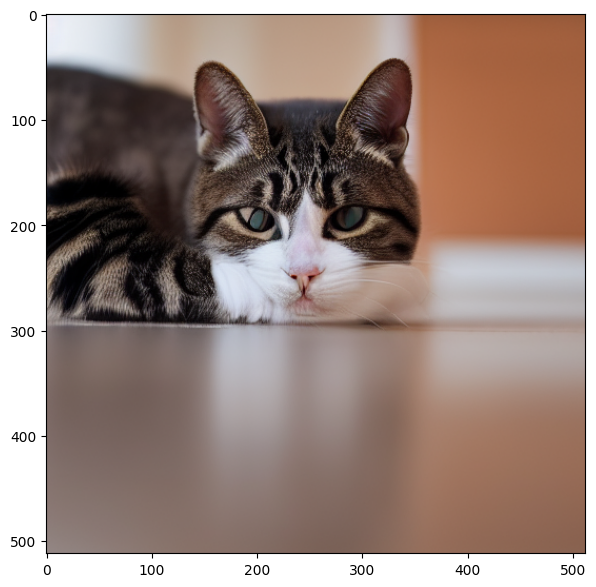

In [51]:
# https://github.com/hkproj/pytorch-stable-diffusion/blob/main/sd/demo.ipynb

# text2img
prompt = "A cat stretching on the floor, highly detailed, ultra sharp, cinematic, 100mm lens, 8k resolution."
uncond_prompt = ""  # можно использовать как негативный промпт
do_cfg = True
cfg_scale = 8  # min: 1, max: 14

# img2img
input_image = None
image_path = "../images/dog.jpg"
# input_image = Image.open(image_path)  # закомментируйте для режима text2img
strength = 0.9  # количество шума на изображении [0, 1], чем выше значение тем сильнее модель "воображает"

# samler
sampler = "ddpm"
num_inference_steps = 50
seed = 42

out_image = pipeline.generate(
    prompt=prompt,
    uncond_prompt=uncond_prompt,
    input_image=input_image,
    strength=strength,
    do_cfg=do_cfg,
    cfg_scale=cfg_scale,
    sampler_name=sampler,
    n_inference_steps=num_inference_steps,
    seed=seed,
    models=models,
    device=DEVICE,
    idle_device="cpu",
    tokenizer=tokenizer,
)

gen_img = Image.fromarray(out_image)
_ = plt.figure(figsize=(7, 7))
_ = plt.imshow(gen_img)

### **[2 балла] Feedback**

Напишите ваши эмоции от этого домашнего задания, было ли оно интересным, оцените сложность, затраты по времени и т.п., все что пожелаете :)